In [102]:
%load_ext autoreload
%autoreload 2

DEVICE = "cpu" # cpu/cuda
RETRAIN = False

if DEVICE == "cpu":
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("./../..")

import torch
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

from image_gen import GenerativeModel
from image_gen.diffusion import VarianceExploding, VariancePreserving, SubVariancePreserving
from image_gen.noise import LinearNoiseSchedule, CosineNoiseSchedule
from image_gen.samplers import EulerMaruyama, ExponentialIntegrator, ODEProbabilityFlow, PredictorCorrector


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device = torch.device(DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of threads: 12


In [103]:
# Dataset MINST
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
print(type(data))

<class 'torchvision.datasets.mnist.MNIST'>


In [104]:
# Create a subset dataset composed of only images of one of the digits
digit = 3
indices_digit = torch.where(data.targets == digit)[0]

data_train = Subset(data, indices_digit)
print(type(data_train))

<class 'torch.utils.data.dataset.Subset'>


In [105]:
diffusion_model = "vp"
noise_schedule = "c"
sampler = "exp"

schedule_map = {
    "l": LinearNoiseSchedule(beta_min=0.0001, beta_max=1000.),
    "c": CosineNoiseSchedule(),
}

diffusion_map = {
    "ve": VarianceExploding,
    "vp": VariancePreserving,
    "svp": SubVariancePreserving
}

sampler_map = {
    "euler": EulerMaruyama,
    "exp": ExponentialIntegrator,
    "ode": ODEProbabilityFlow,
    "pc": PredictorCorrector
}

model = GenerativeModel(
    diffusion=diffusion_map.get(diffusion_model),
    sampler=sampler_map.get(sampler),
    noise_schedule=schedule_map.get(noise_schedule)
)

# Add input validation for diffusion model, noise schedule, and sampler
if diffusion_model not in diffusion_map:
    raise ValueError(f"Invalid diffusion model: {diffusion_model}")
if noise_schedule not in schedule_map:
    raise ValueError(f"Invalid noise schedule: {noise_schedule}")
if sampler not in sampler_map:
    raise ValueError(f"Invalid sampler: {sampler}")

In [106]:
epochs = 20
model.train(data_train, epochs=epochs, lr=0.01)
# model.save(f'mnist_{digit}_{epochs}e_{diffusion_model}_{sampler}.pth')
# model.load(f'mnist_{digit}_{epochs}e_{diffusion_model}_{sampler}.pth')

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/192 [00:00<?, ?it/s]

In [107]:
n_images = 16
samples = model.generate(n_images)

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

In [108]:
def show_images(images, n_images=4):
    images = images[:n_images]  # Select only the first n_images
    images = images.permute(0, 2, 3, 1).cpu().detach().numpy()
    images = (images + 1) / 2  # Scale from [-1,1] to [0,1]
    
    grid_size = int(np.sqrt(n_images))  # Ensure a square-like grid
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(4, 4))
    axes = axes.flatten()
    
    for idx, img in enumerate(images):
        axes[idx].imshow(img, cmap="gray")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [109]:
def show_mnist_images(dataset, n_images=4):
    fig, axes = plt.subplots(int(np.sqrt(n_images)), int(np.sqrt(n_images)), figsize=(4, 4))
    axes = axes.flatten()
    
    for i in range(n_images):
        img, label = dataset[i]  # Get image and label
        img = img.squeeze().numpy()  # Convert to 2D array
        
        axes[i].imshow(img, cmap='gray')  # Display in grayscale
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

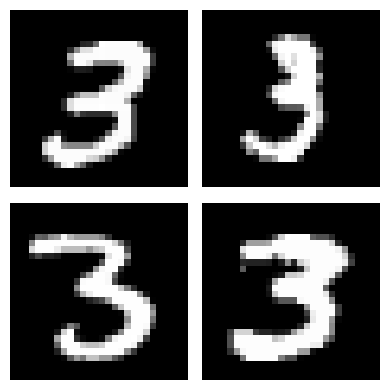

In [110]:
show_mnist_images(data_train, n_images=4)

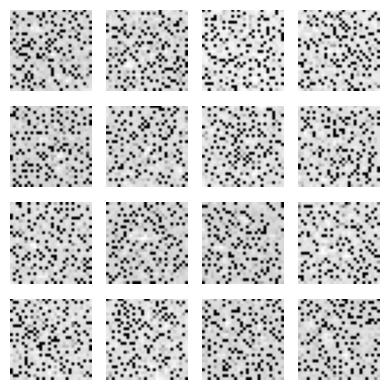

In [111]:
show_images(samples, n_images=n_images)

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Error computing score at step 0, t=1.0: index out of range in self
Error computing score at step 1, t=0.9980019927024841: index out of range in self
Error computing score at step 2, t=0.9960039854049683: index out of range in self
Error computing score at step 3, t=0.9940059781074524: index out of range in self
Error computing score at step 4, t=0.9920079708099365: index out of range in self
Error computing score at step 5, t=0.9900100231170654: index out of range in self
Error computing score at step 6, t=0.9880120158195496: index out of range in self
Error computing score at step 7, t=0.9860140085220337: index out of range in self
Error computing score at step 8, t=0.9840160012245178: index out of range in self
Error computing score at step 9, t=0.982017993927002: index out of range in self
Error computing score at step 10, t=0.9800199866294861: index out of range in self
Error computing score at step 11, t=0.9780219793319702: index out of range in self
Error computing score at step 

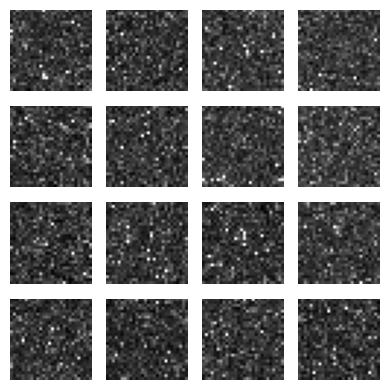

In [112]:
n_images = 16
samples = model.generate(n_images, class_labels=3)
show_images(samples, n_images=n_images)

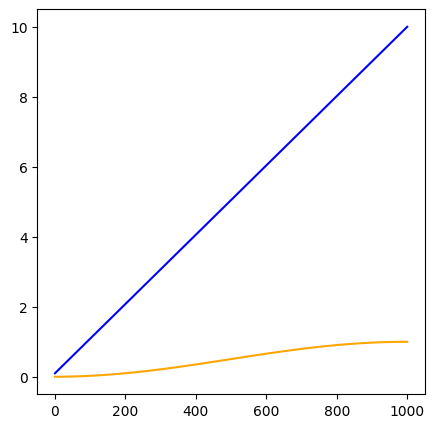

In [113]:
import matplotlib.pyplot as plt

max_t = 1000.0
beta_max = 10.0
x = torch.linspace(0, max_t, 100)

plt.figure(figsize=(5, 5))

lin_schedule = LinearNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, lin_schedule(x), label='Linear Schedule', color='blue')

cos_schedule = CosineNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, cos_schedule(x), label='Cosine Schedule', color='orange')